<a href="https://colab.research.google.com/github/Tyriek-cloud/Cox-Hazard-Model-Simulation/blob/main/Simulated_Data_Cox_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cox Proportional-Hazards Model on Synthetic Data**

In [1]:
# First, we shall install the necessary libraries to build a base model
!pip install lifelines pandas numpy scikit-learn gradio matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=9c63be5e6098df3cf3b20e1664a155c5cb2c5ac7ee5bae56274330ab11c5a76d
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


Alright. Let's start by doing the folloiwng:

*   Import all of the installed libraries.
*   Generate the synthetic/fake data.
*   Put all the data into an easy to work with dataframe.
*   Take a look at the data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Set a random seed for reproducibility
np.random.seed(42)

# Generate Independent variables (IVs)
n = 2000  # number of samples
age = np.random.randint(22, 65, n)
sex = np.random.choice(['Male', 'Female'], n)
income = np.random.normal(50000, 15000, n)
usage_frequency = np.random.randint(1, 8, n)
engagement = np.random.normal(5, 2, n)
satisfaction = np.random.normal(7, 1.5, n)

# Dependent variables (DV)
time_to_event = np.random.exponential(5, n)
censor = np.random.binomial(1, 0.8, n)

# Confounding variables
time_of_year = np.random.choice(['Winter', 'Spring', 'Summer', 'Fall'], n)
service_changes = np.random.choice([0, 1], n)

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'sex': sex,
    'income': income,
    'usage_frequency': usage_frequency,
    'engagement': engagement,
    'satisfaction': satisfaction,
    'time_to_event': time_to_event,
    'censor': censor,
    'time_of_year': time_of_year,
    'service_changes': service_changes
})

# Handle categorical variables (e.g., sex and time_of_year)
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df['time_of_year'] = label_encoder.fit_transform(df['time_of_year'])

# Impute any missing data (in case there are any NaN values)
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Create the CoxPH model and fit it to the data
cph = CoxPHFitter()

# Fit the Cox model using the time_to_event and censor as survival data
cph.fit(df_imputed, duration_col='time_to_event', event_col='censor')

# Print the model summary
print(cph.summary)

                         coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                            
age              5.589372e-04   1.000559  0.002069       -0.003497   
sex              5.543253e-03   1.005559  0.050430       -0.093298   
income          -1.068146e-08   1.000000  0.000002       -0.000003   
usage_frequency -1.088107e-02   0.989178  0.012517       -0.035414   
engagement      -2.681184e-02   0.973544  0.012735       -0.051772   
satisfaction     1.663381e-02   1.016773  0.016765       -0.016224   
time_of_year    -7.407235e-04   0.999260  0.022525       -0.044889   
service_changes  4.381156e-02   1.044785  0.050420       -0.055010   

                 coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                   
age                    0.004615             0.996509             1.004625   
sex                    0.104385             0.910922             1.1

That looks okay. Engagement is properly the worse performing variable.I definitely need to be careful about handling that in the analysis. The data is obviously not going to reflect real-world conditions, but that does not mean I cannot take real world precautions.

Using more powerful models may prove to be a much better approach. Let's try two Gradient Boosters in seperate notebooks.

First, let's look at how this model performs (probably going to be mediocre from what I see above).

In [3]:
# Evaluate the model's concordance index (C-index)
c_index = concordance_index(df_imputed['time_to_event'], cph.predict_partial_hazard(df_imputed), df_imputed['censor'])
print(f'Concordance index: {c_index}')

Concordance index: 0.4741427924276233


That is a better score than I was suspecting. However, more powerful models should perform far better. For now, let's just plot a curve.

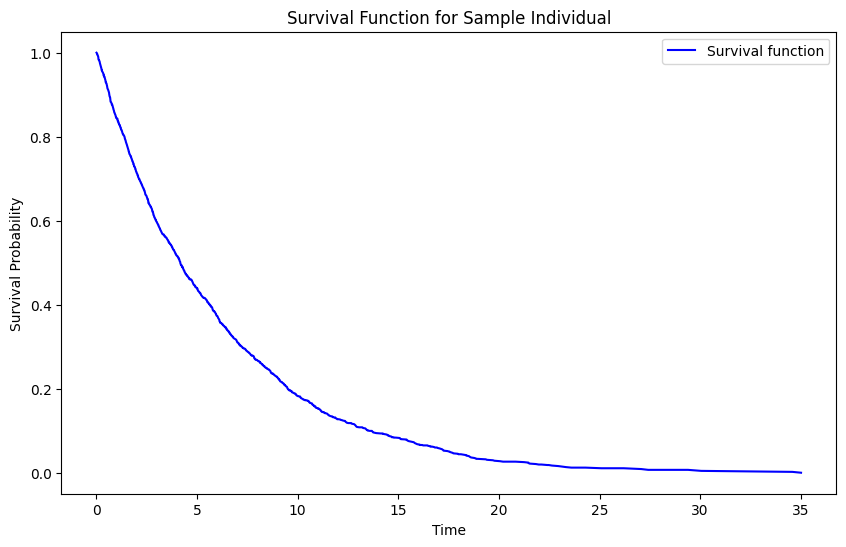

In [4]:
# Plot the survival function for a sample individual
sample_individual = df_imputed.iloc[[0]]  # Get the first row as a DataFrame
sample_individual = sample_individual.drop(['time_to_event', 'censor'], axis=1)

# Predict the survival function for this individual
survival_function = cph.predict_survival_function(sample_individual)

# Plot the survival function
plt.figure(figsize=(10, 6))
# Using survival_function.index as x and the single survival probability value as y
plt.plot(survival_function.index, survival_function.iloc[:, 0], label="Survival function", color='blue')
plt.title("Survival Function for Sample Individual")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()